<a href="https://colab.research.google.com/github/AyonSOMADDAR/100-pandas-puzzles/blob/master/Road_Sign_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.image as mpimg
import os

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from keras import layers
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
from glob import glob
import cv2

import warnings
warnings.filterwarnings('ignore')


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17529761185695362466
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 765269286015645065
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [5]:
# Extracting the compressed dataset.
from zipfile import ZipFile 
data_path = r'/content/drive/MyDrive/indian traffic dataset 2.zip' 
with ZipFile(data_path, 'r') as zip:
  zip.extractall()


In [6]:
# path to the folder containing our dataset
dataset = '/content/Indian-Traffic Sign-Dataset/Images'

# path of label file
labelfile = pd.read_csv('/content/Indian-Traffic Sign-Dataset/traffic_sign.csv')


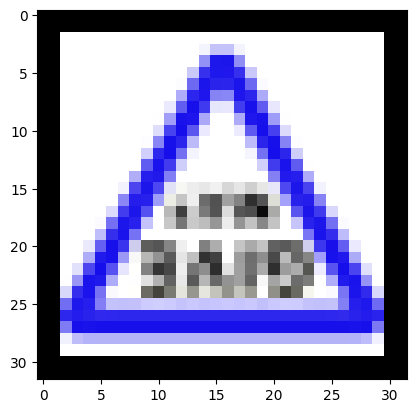

In [7]:
# Visualize some images from the dataset
img = cv2.imread("/content/Indian-Traffic Sign-Dataset/Images/0/0_original_43.png_592b345c-34ee-4cc5-b2f4-774db9375ab8.png")
plt.imshow(img)


In [8]:
labelfile.head()



,ClassId,Name
0,0,Give way
1,1,No entry
2,2,One-way traffic
3,3,One-way traffic
4,4,No vehicles in both directions


In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset, validation_split=0.2,
															subset='training',
															image_size=(
																224, 224),
															seed=123,
															batch_size=32)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(dataset, validation_split=0.2,
															subset='validation',
															image_size=(
																224, 224),
															seed=123,
															batch_size=32)


Found 13971 files belonging to 58 classes.
Using 11177 files for training.
Found 13971 files belonging to 58 classes.
Using 2794 files for validation.


In [10]:
class_numbers = train_ds.class_names
class_names = []
for i in class_numbers:
	class_names.append(labelfile['Name'][int(i)])


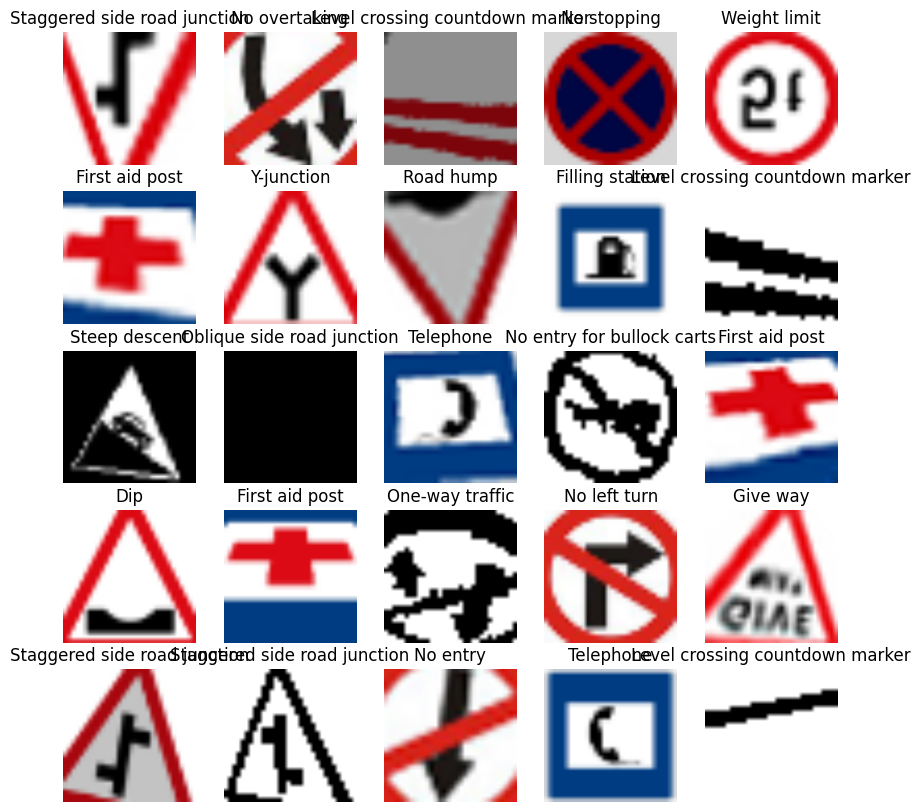

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
	for i in range(25):
		ax = plt.subplot(5, 5, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

plt.show()


In [12]:
data_augmentation = tf.keras.Sequential(
	[
		tf.keras.layers.experimental.preprocessing.RandomFlip(
			"horizontal", input_shape=(224, 224, 3)),
		tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
		tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
		tf.keras.layers.experimental.preprocessing.RandomFlip(
			mode="horizontal_and_vertical")
	]
)


In [13]:
model = Sequential()
model.add(data_augmentation)
model.add(Rescaling(1./255))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(labelfile), activation='softmax'))


In [14]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                  

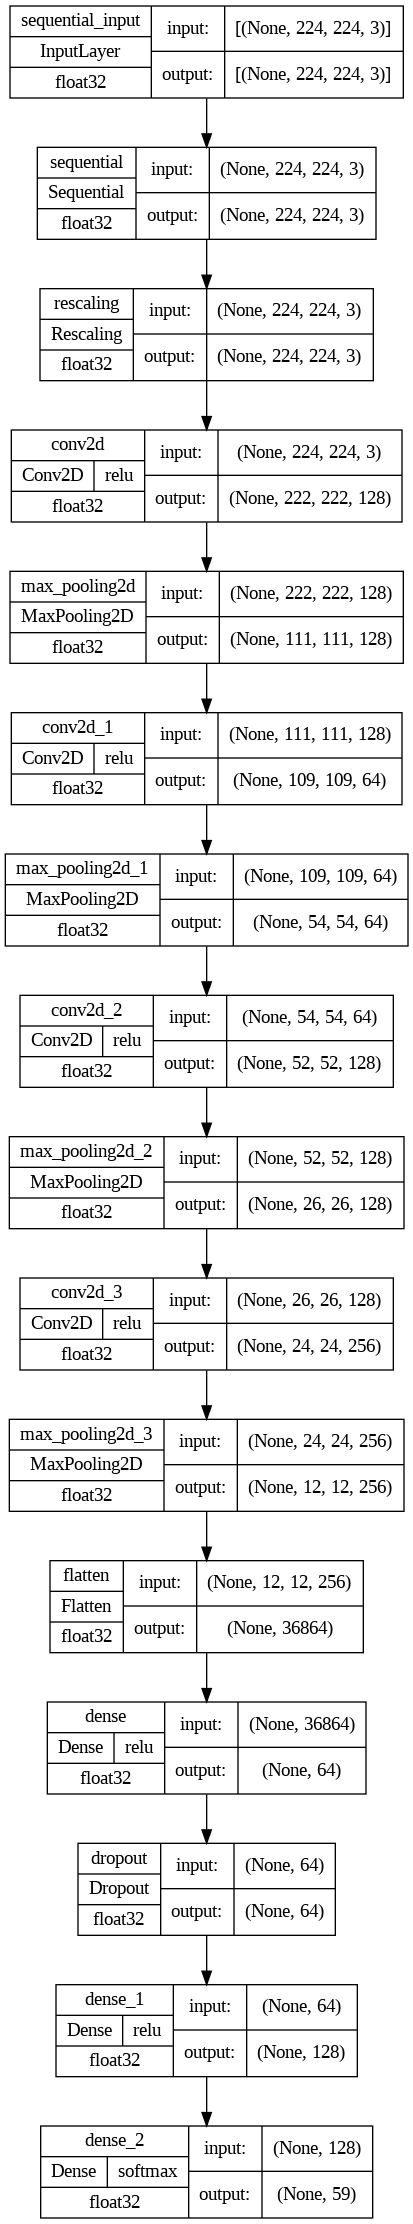

In [15]:
keras.utils.plot_model(
	model,
	show_shapes=True,
	show_dtype=True,
	show_layer_activations=True
)


In [16]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
			optimizer='adam',
			metrics=['accuracy'])


In [17]:
# Set callback functions to early stop training
mycallbacks = [EarlyStopping(monitor='val_loss', patience=5)]
history = model.fit(train_ds,
				validation_data=val_ds,
				epochs=50,
				callbacks=mycallbacks)


Epoch 1/50
350/350 [==============================] - 59s 126ms/step - loss: 3.3454 - accuracy: 0.1324 - val_loss: 2.7137 - val_accuracy: 0.2062
Epoch 2/50
350/350 [==============================] - 43s 122ms/step - loss: 2.7645 - accuracy: 0.2099 - val_loss: 2.1768 - val_accuracy: 0.3293
Epoch 3/50
350/350 [==============================] - 44s 124ms/step - loss: 2.3429 - accuracy: 0.2911 - val_loss: 1.7416 - val_accuracy: 0.4792
Epoch 4/50
350/350 [==============================] - 43s 122ms/step - loss: 2.0878 - accuracy: 0.3648 - val_loss: 1.4961 - val_accuracy: 0.5437
Epoch 5/50
350/350 [==============================] - 43s 122ms/step - loss: 1.9098 - accuracy: 0.4121 - val_loss: 1.3666 - val_accuracy: 0.5759
Epoch 6/50
350/350 [==============================] - 45s 129ms/step - loss: 1.7890 - accuracy: 0.4490 - val_loss: 1.2644 - val_accuracy: 0.6038
Epoch 7/50
350/350 [==============================] - 43s 123ms/step - loss: 1.6829 - accuracy: 0.4760 - val_loss: 1.1235 - val_ac

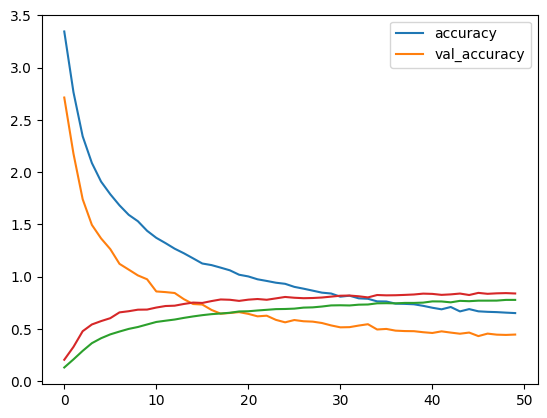

In [19]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'], loc='upper right')

# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'], loc='upper right')


Enter image path that you want to predict/content/test_sign.jfif
1/1 [==============================] - 0s 23ms/step
No entry for pedestrians


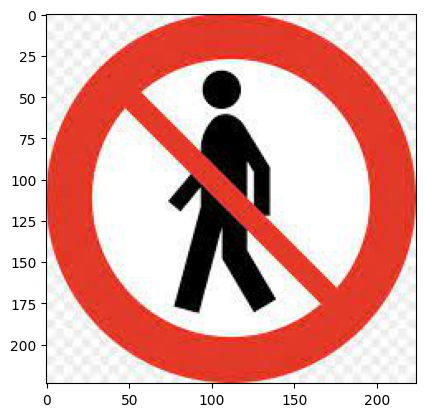

In [36]:
img_path=input("Enter image path that you want to predict")
img = tf.keras.utils.load_img( img_path, target_size=(224, 224))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
plt.imshow(img)
score = tf.nn.softmax(model.predict(img_array))
print(class_names[np.argmax(score)])
